## Assignment 7 - Health Care Fraud Detection

## Section 1: Data Prep <a class="anchor" id="Section_1"></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as stats
import plotly.io as pio
pio.renderers.default = "notebook"

In [6]:
data = pd.read_csv("/content/drive/MyDrive/5420 anomaly/Assignment/assignment_7/inpatientCharges.csv")
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']
data = data.drop('Average_Covered_Charges',axis=1)

# Change data type and transfer spending amount with dollar sign into numeric
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Hospital_referral_region_desp'] = data['Hospital_referral_region_desp'].astype('category')
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))

data.head()

<ipython-input-6-7bf01c522293>:15: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-6-7bf01c522293>:17: FutureWarning:

The default value of regex will change from True to False in a future version.



,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,4851.44


## Section 2: Features <a class="anchor" id="Section_3"></a>

### Section 2.1a DRG's 95% CI of Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may heavily abuse the resources compared to the 95% of its peers of the same DRG.**

In [7]:
grouped = data.groupby(['DRG'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
drg_95 = pd.DataFrame({'Mean': mean, 'Std': std})

# add the new feature average spending to the dataset
drg_95 = data.merge(drg_95, on='DRG', how='left')

drg_95['upper_CI'] = np.where(drg_95['Mean']==0, 0, drg_95['Mean'] + 1.96*drg_95['Std'])
drg_95.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Total_Payments,Average_Medicare_Payment,Mean,Std,upper_CI
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,5777.24,4763.73,6960.534004,1477.873952,9857.166949
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,5787.57,4976.71,6960.534004,1477.873952,9857.166949
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,5434.95,4453.79,6960.534004,1477.873952,9857.166949
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,5417.56,4129.16,6960.534004,1477.873952,9857.166949
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,5658.33,4851.44,6960.534004,1477.873952,9857.166949


In [8]:
#Filter out average total payment is over 95% of the upper confidence interval
outlier = drg_95[(drg_95['Average_Total_Payments']>drg_95['upper_CI']) & (drg_95['upper_CI'] >= 0)]
filtered_outlier = outlier[['DRG', 'Provider_Name', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.head()

,DRG,Provider_Name,Average_Total_Payments,upper_CI
31,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,FLAGSTAFF MEDICAL CENTER,11026.33,9857.166949
36,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SUMMIT HEALTHCARE REGIONAL MEDICAL CENTER,10000.82,9857.166949
67,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MERCY GENERAL HOSPITAL,10863.22,9857.166949
73,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,GLENDALE MEM HOSPITAL & HLTH CENTER,11082.18,9857.166949
88,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,JOHN MUIR MEDICAL CENTER - WALNUT CREEK CAMPUS,12355.85,9857.166949


### Section 2.1b DRG's of Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of average total payments from its peers with the same DRG.**

In [9]:
drg_avg = data.groupby(['DRG'])['Average_Total_Payments'].mean().reset_index()
drg_avg.columns = ['DRG','Avg_Payment_ByStateDRG']

drg_avg = pd.merge(data, drg_avg, how='left', on=['DRG'])

drg_avg['drg_avg_ratio'] = np.where(drg_avg['Avg_Payment_ByStateDRG']==0,0, drg_avg['Average_Total_Payments'] / drg_avg['Avg_Payment_ByStateDRG'])
drg_avg['drg_avg_ratio'].describe()

count    163065.000000
mean          1.000000
std           0.248259
min           0.464005
25%           0.839686
50%           0.928391
75%           1.085989
max           9.449417
Name: drg_avg_ratio, dtype: float64

### Section 2.1c DRG's of Median Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments from its peers with the same DRG. Also, median benchmark is somewhat useful compared to average measurement because the outliers could distort the mean values of data.**

In [10]:
med_drg = data.groupby(['DRG'])['Average_Total_Payments'].mean()
med_drg = pd.DataFrame(med_drg)
med_drg.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset
med_drg = pd.merge(data, med_drg, how='left', on=['DRG'])

med_drg['drg_median_ratio_amount'] = np.where(med_drg['Median_avg_total_payments']==0,0, med_drg['Average_Total_Payments'] / med_drg['Median_avg_total_payments'])
med_drg['drg_median_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.248259
min           0.464005
25%           0.839686
50%           0.928391
75%           1.085989
max           9.449417
Name: drg_median_ratio_amount, dtype: float64

### Section 2.2a: State & DRG's 95% CI of Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to the 95% of its peers of the same DRG within the same State.**

In [11]:
state_drg_95 = data.groupby(['DRG', 'Provider_State'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
state_drg_95 = pd.DataFrame({'Mean': mean, 'Std': std}).reset_index()

# add the new feature average spending to the dataset
state_drg_95 = data.merge(state_drg_95, on='DRG', how='left')

state_drg_95['upper_CI'] = np.where(state_drg_95['Mean']==0, 0, state_drg_95['Mean'] + 1.96*state_drg_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = state_drg_95[(state_drg_95['Average_Total_Payments']>state_drg_95['upper_CI']) & (state_drg_95['upper_CI'] >= 0)]
filtered_outlier = outlier[['DRG', 'Provider_Name', 'Provider_State', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.tail()

,DRG,Provider_Name,Provider_State,Average_Total_Payments,upper_CI
162822,948 - SIGNS & SYMPTOMS W/O MCC,MEMORIAL HERMANN TEXAS MEDICAL CENTER,TX,7910.32,7474.839233
162893,948 - SIGNS & SYMPTOMS W/O MCC,LAMB HEALTHCARE CENTER,TX,8241.50,7474.839233
162934,948 - SIGNS & SYMPTOMS W/O MCC,MEDICAL COLLEGE OF VIRGINIA HOSPITALS,VA,8760.77,7474.839233
162972,948 - SIGNS & SYMPTOMS W/O MCC,UNIVERSITY OF WASHINGTON MEDICAL CTR,WA,8771.80,7474.839233
163063,948 - SIGNS & SYMPTOMS W/O MCC,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,TX,7663.09,7474.839233


### Section 2.2b: State & DRG's Average Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of average total payments from its peers under the same DRG and State.**

In [12]:
drg_state_avg = data.groupby(['DRG', 'Provider_State'])['Average_Total_Payments'].mean().reset_index()
drg_state_avg.head()
drg_state_avg.columns = ['DRG', 'Provider_State', 'drg_state_avg_total_payment']

drg_state_avg = pd.merge(data, drg_state_avg, how='left', left_on=['DRG', 'Provider_State'], right_on = ['DRG', 'Provider_State'])

drg_state_avg['drg_state_avg_ratio'] = np.where(drg_state_avg['drg_state_avg_total_payment']==0,0, drg_state_avg['Average_Total_Payments'] / drg_state_avg['drg_state_avg_total_payment'])

The chart also shows few outliers located at the right hand side of the red line while further matching hospitals' state and DRG clinical condition. Also, the distribution here shows a normal distribution.

### Section 2.2c State and DRG's of Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments from its peers under the same DRG within same state.**

In [13]:
med_drg_state = data.groupby(['DRG', 'Provider_State'])['Average_Total_Payments'].mean()
med_drg_state = pd.DataFrame(med_drg_state)
med_drg_state.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset
med_drg_state = pd.merge(data, med_drg_state, how='left', on=['DRG', 'Provider_State'])

med_drg_state['drg_state_median_ratio_amount'] = np.where(med_drg_state['Median_avg_total_payments']==0,0, med_drg_state['Average_Total_Payments'] / med_drg_state['Median_avg_total_payments'])
med_drg_state['drg_state_median_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.195274
min           0.384805
25%           0.880824
50%           0.956830
75%           1.064688
max           7.857934
Name: drg_state_median_ratio_amount, dtype: float64

### Section 2.3a: Hospital_referral_region_desp's 95% CI of Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to the 95% of average total payments from its peers in the same region.**

In [14]:
grouped = data.groupby(['Hospital_referral_region_desp'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
hos_region_95 = pd.DataFrame({'Mean': mean, 'Std': std}).reset_index()
hos_region_95.head()
# add the new feature average spending to the dataset
hos_region_95 = data.merge(hos_region_95, on='Hospital_referral_region_desp', how='left')

hos_region_95['upper_CI'] = np.where(hos_region_95['Mean']==0, 0, hos_region_95['Mean'] + 1.96*hos_region_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = hos_region_95[(hos_region_95['Average_Total_Payments']>hos_region_95['upper_CI']) & (hos_region_95['upper_CI'] >= 0)]
filtered_outlier = outlier[['Provider_Name', 'Hospital_referral_region_desp', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.tail()

,Provider_Name,Hospital_referral_region_desp,Average_Total_Payments,upper_CI
154595,UNIVERSITY OF TEXAS MEDICAL BRANCH GAL,TX - Houston,28615.63,24608.650047
154837,MEDICAL COLLEGE OF VIRGINIA HOSPITALS,VA - Richmond,28604.07,25314.772289
154950,ST JOSEPHS HEALTHCARE SYSTEM,WV - Charleston,20435.93,17894.178616
159452,UNIVERSITY OF MICHIGAN HEALTH SYSTEM,MI - Ann Arbor,33251.14,27827.030713
162713,CANCER TREATMENT CENTERS OF AMERICA,PA - Philadelphia,28968.20,26668.033820


### Section 2.3b: Hospital_referral_region_desp's Average Total Payment
**Assumpton: Hospitals may abuse the resources compared to 2 times of average total payments from its peers in the same region.**

In [15]:
hos_region_avg = data.groupby(['Hospital_referral_region_desp'])['Average_Total_Payments'].mean().reset_index()
hos_region_avg.columns = ['Hospital_referral_region_desp','hos_region_avg_total_payment']

hos_region_avg = pd.merge(data, hos_region_avg, how='left', on=['Hospital_referral_region_desp'])

hos_region_avg['hos_region_avg_ratio'] = np.where(hos_region_avg['hos_region_avg_total_payment']==0,0, hos_region_avg['Average_Total_Payments'] / hos_region_avg['hos_region_avg_total_payment'])

The outliers are basically located at the right hand side of the red line while further matching hospitals' region. Also, the distribution here shows a normal distribution.

### Section 2.3c Hospital_referral_region_desp's of Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments from its peers in the same region.**

In [16]:
med_hos = data.groupby(['Hospital_referral_region_desp'])['Average_Total_Payments'].mean()
med_hos = pd.DataFrame(med_hos)
med_hos.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset
med_hos = pd.merge(data, med_hos, how='left', on=['Hospital_referral_region_desp'])

med_hos['hos_median_ratio_amount'] = np.where(med_hos['Median_avg_total_payments']==0,0, med_hos['Average_Total_Payments'] / med_hos['Median_avg_total_payments'])
med_hos['hos_median_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.747571
min           0.238224
25%           0.553887
50%           0.754392
75%           1.174096
max          14.354180
Name: hos_median_ratio_amount, dtype: float64

### Section 2.4a: Total Discharges over 95% of Average Total Payments
**Assumpton: If the total discharges are comparably low but the average payment is higher than 95% of confidence interval, the fraudulent transaction might happen.**

The total discharges indicate the number of beneficiaries who were released from the inpatient hospital after receiving care.

In [17]:
grouped = data.groupby(['Total_Discharges'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
dis_95 = pd.DataFrame({'Mean': mean, 'Std': std})

# add the new feature average spending to the dataset
dis_95 = data.merge(dis_95, on='Total_Discharges', how='left')

dis_95['upper_CI'] = np.where(dis_95['Mean']==0, 0, dis_95['Mean'] + 1.96*dis_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = dis_95[(dis_95['Average_Total_Payments']>dis_95['upper_CI']) & (dis_95['upper_CI'] >= 0)]
filtered_outlier = outlier[['Provider_Name', 'Total_Discharges', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.head()

,Provider_Name,Total_Discharges,Average_Total_Payments,upper_CI
1554,"JOHNS HOPKINS HOSPITAL, THE",83,24865.61,21460.955088
1566,JOHNS HOPKINS BAYVIEW MEDICAL CENTER,103,19700.60,15601.612665
2384,COMMUNITY REGIONAL MEDICAL CENTER,107,18392.02,18119.595713
2420,JOHN MUIR MEDICAL CENTER - WALNUT CREEK CAMPUS,72,24440.79,21398.792999
2422,WASHINGTON HOSPITAL,50,22851.80,22057.377241


### Section 2.4b: Total Discharges over mean average total payments
**Assumpton: If the total discharges are comparably low but the average payment is higher than 2 times of average, the fraudulent transaction might happen.**

The total discharges indicate the number of beneficiaries who were released from the inpatient hospital after receiving care.

In [18]:
dis_avg = data.groupby(['Total_Discharges'])['Average_Total_Payments'].mean().reset_index()
dis_avg.head()
dis_avg.columns = ['Total_Discharges', 'dis_avg_total_payment']

dis_avg = pd.merge(data, dis_avg, how='left', on=['Total_Discharges'])

dis_avg['dis_avg_ratio'] = np.where(dis_avg['dis_avg_total_payment']==0,0, dis_avg['Average_Total_Payments'] / dis_avg['dis_avg_total_payment'])

### Section 2.4c Total Discharges over Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments compared to same level of total discharges**

In [19]:
med_total_discharges = data.groupby(['Total_Discharges'])['Average_Total_Payments'].mean()
med_total_discharges = pd.DataFrame(med_total_discharges)
med_total_discharges.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset
med_total_discharges = pd.merge(data, med_total_discharges, how='left', on=['Total_Discharges'])

med_total_discharges['med_total_discharges_ratio_amount'] = np.where(med_hos['Median_avg_total_payments']==0,0, med_hos['Average_Total_Payments'] / med_hos['Median_avg_total_payments'])
med_total_discharges['med_total_discharges_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.747571
min           0.238224
25%           0.553887
50%           0.754392
75%           1.174096
max          14.354180
Name: med_total_discharges_ratio_amount, dtype: float64

### Section 2.5a: Provider name's 95% CI of Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to the 95% of average total payments from its own average total payment.**

In [20]:
grouped = data.groupby(['Provider_Name'])['Average_Total_Payments']
mean = grouped.mean()
std = grouped.std()

# Create a benchmark within 95% of confidence interval
name_95 = pd.DataFrame({'Mean': mean, 'Std': std}).reset_index()
name_95.head()
# add the new feature average spending to the dataset
name_95 = data.merge(name_95, on='Provider_Name', how='left')

name_95['upper_CI'] = np.where(name_95['Mean']==0, 0, name_95['Mean'] + 1.96*name_95['Std'])

#Filter out average total payment is over 95% of the upper confidence interval
outlier = name_95[(name_95['Average_Total_Payments']>name_95['upper_CI']) & (name_95['upper_CI'] >= 0)]
filtered_outlier = outlier[['Provider_Id', 'Provider_Name', 'Provider_State', 'Average_Total_Payments', 'upper_CI']]

filtered_outlier.tail()

,Provider_Id,Provider_Name,Provider_State,Average_Total_Payments,upper_CI
154962,510082,SUMMERSVILLE REGIONAL MEDICAL CENTER,WV,11358.28,11318.413858
155021,520204,"WHEATON FRANCISCAN HEALTHCARE- FRANKLIN, INC",WI,11828.43,10893.517928
155024,530002,CAMPBELL COUNTY MEMORIAL HOSPITAL,WY,19201.38,18760.738641
155028,670002,SOUTH HAMPTON COMMUNITY HOSPITAL,TX,13671.91,13624.569648
155043,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,TX,18468.00,18437.346165


### Section 2.5b: Provider name's Mean Average Total Payment
**Assumpton: Hospitals may abuse the resources compared to 2 times of average total payments from its own average total payment.**

In [21]:
name_avg = data.groupby(['Provider_Name'])['Average_Total_Payments'].mean().reset_index()
name_avg.columns = ['Provider_Name','name_avg_total_payment']

name_avg = pd.merge(data, name_avg, how='left', on=['Provider_Name'])

name_avg['name_avg_ratio'] = np.where(name_avg['name_avg_total_payment']==0,0, name_avg['Average_Total_Payments'] / name_avg['name_avg_total_payment'])

### Section 2.5c Provider Name's Median Average Total Payment <a class="anchor" id="Section_31"></a>
**Assumption: Hospitals may abuse the resources compared to 2 times of median total payments under same provider.**

In [22]:
med_name = data.groupby(['Provider_Name'])['Average_Total_Payments'].mean()
med_name = pd.DataFrame(med_name)
med_name.columns = ['Median_avg_total_payments']

# add the new feature median spending to the dataset
med_name = pd.merge(data, med_name, how='left', on=['Provider_Name'])

med_name['med_hos_ratio_amount'] = np.where(med_name['Median_avg_total_payments']==0,0, med_name['Average_Total_Payments'] / med_name['Median_avg_total_payments'])
med_name['med_hos_ratio_amount'].describe()

count    163065.000000
mean          1.000000
std           0.683008
min           0.142642
25%           0.578467
50%           0.779055
75%           1.189022
max           8.268243
Name: med_hos_ratio_amount, dtype: float64

## Section 3. Models

### Combinations of Feature
These include ratio and upper confidence interval features in combination

In [23]:
from sklearn.preprocessing import StandardScaler

feature_ratio = pd.concat([drg_avg['drg_avg_ratio'], med_drg['drg_median_ratio_amount'], drg_state_avg['drg_state_avg_ratio'], med_drg_state['drg_state_median_ratio_amount'],
    hos_region_avg['hos_region_avg_ratio'], med_hos['hos_median_ratio_amount'], dis_avg['dis_avg_ratio'], med_total_discharges['med_total_discharges_ratio_amount'],
    name_avg['name_avg_ratio'], med_name['med_hos_ratio_amount']], axis=1)

feature_ratio = StandardScaler().fit_transform(feature_ratio)
feature_ratio = pd.DataFrame(feature_ratio)

feature_upper = pd.concat([drg_95['upper_CI'], state_drg_95['upper_CI'], hos_region_95['upper_CI'], dis_95['upper_CI'], name_95['upper_CI']], axis=1)
feature_upper.columns = ['drg_upper', 'state_drg_upper', 'hos_region_upper', 'dis_upper', 'name_upper']
feature_upper = feature_upper.fillna(feature_upper.mean())
feature_upper = StandardScaler().fit_transform(feature_upper)
feature_upper = pd.DataFrame(feature_upper)


### Autoencoder

1. An unsupervised artificial neural network technique
2. Includes encoder and decoder to reconstruct the original input
3. Reduce the noise of dataset, especially with the data that consists a large number of variables
4. Perform non-linear transformations with non-linear activation functions and multiple layers

In [24]:
!pip install pyomo
!pip install pyod
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185331 sha256=360a307231c09485b1cfa303b80c00e5ac666e8b30b18417aa2bcda708c5f915
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


**Autoencoder: Ratio Feature**

In [25]:
from sklearn.decomposition import PCA
pca = PCA(2)
r_pca = pca.fit_transform(feature_ratio)
r_pca = pd.DataFrame(r_pca)
r_pca.columns=['PC1','PC2']
r_pca.head()

,PC1,PC2
0,-1.020776,-0.325024
1,-0.971876,-0.379635
2,-1.434572,-0.737325
3,-1.446123,-0.759944
4,-1.200945,-0.479696


In [26]:
#upper feature
u_pca = pca.fit_transform(feature_upper)
u_pca = pd.DataFrame(u_pca)
u_pca.columns=['PC1','PC2']
u_pca.head()

,PC1,PC2
0,-1.050460,-0.698073
1,-1.050628,-1.680165
2,-0.832309,-1.089656
3,-0.849339,-1.068325
4,-0.913892,-1.287626



#### Model 1
* clf1 has hidden_neurons = [25, 2, 2, 25]

**Ratio Feature**

In [27]:
#ratio feature
clf1_r = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1_r.fit(feature_ratio)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                275       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 5

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x790285ac6cb0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

**Upper Feature**

In [28]:
#upper feature
clf1_u = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1_u.fit(feature_upper)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 5)                 30        
                                                                 
 dropout_6 (Dropout)         (None, 5)                 0         
                                                                 
 dense_8 (Dense)             (None, 5)                 30        
                                                                 
 dropout_7 (Dropout)         (None, 5)                 0         
                                                                 
 dense_9 (Dense)             (None, 25)                150       
                                                                 
 dropout_8 (Dropout)         (None, 25)                0         
                                                                 
 dense_10 (Dense)            (None, 2)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x790285ac6cb0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

##### Outlier Score

In [29]:
r_scores = clf1_r.decision_function(feature_ratio)
r_pred = clf1_r.predict(feature_ratio)

u_scores = clf1_u.decision_function(feature_upper)
u_pred = clf1_u.predict(feature_upper)
print({'ratio outlier scores': r_scores, 'upper confidence interval outlier scores': u_scores})
print({'ratio prediction': r_pred, 'upper confidence interval prediction': u_pred})


5096/5096 [==============================] - 7s 1ms/step
{'ratio outlier scores': array([1.33348379, 1.28371703, 1.73866015, ..., 2.35477503, 5.86303913,
       2.98485147]), 'upper confidence interval outlier scores': array([2.67073992, 2.03082609, 1.5918339 , ..., 1.2244976 , 1.25685236,
       1.73932556])}
{'ratio prediction': array([0, 0, 0, ..., 0, 1, 0]), 'upper confidence interval prediction': array([2.67073992, 2.03082609, 1.5918339 , ..., 1.2244976 , 1.25685236,
       1.73932556])}


In [92]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The ratio data:", count_stat(r_pred))
print("The threshold for the defined contamination rate:" , clf1_r.threshold_)

The ratio data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 3.898513936991141


In [93]:
def print_dict_head(d, n=5):
    # create an iterator of key-value pairs and convert to list
    items = list(d.items())
    # print the first n items
    for k, v in items[:n]:
        print(f'{k}: {v}')

u_pred_stats = count_stat(u_pred)
print("The upper confidence interval data:")
print_dict_head(u_pred_stats)

print("The threshold for the defined contamination rate:", clf1_u.threshold_)


The upper confidence interval data:
0.04098576327245369: 1
0.10325729138121306: 1
0.11768017499573111: 1
0.12888140306484627: 1
0.14428011347945527: 1
The threshold for the defined contamination rate: 2.916606557437916


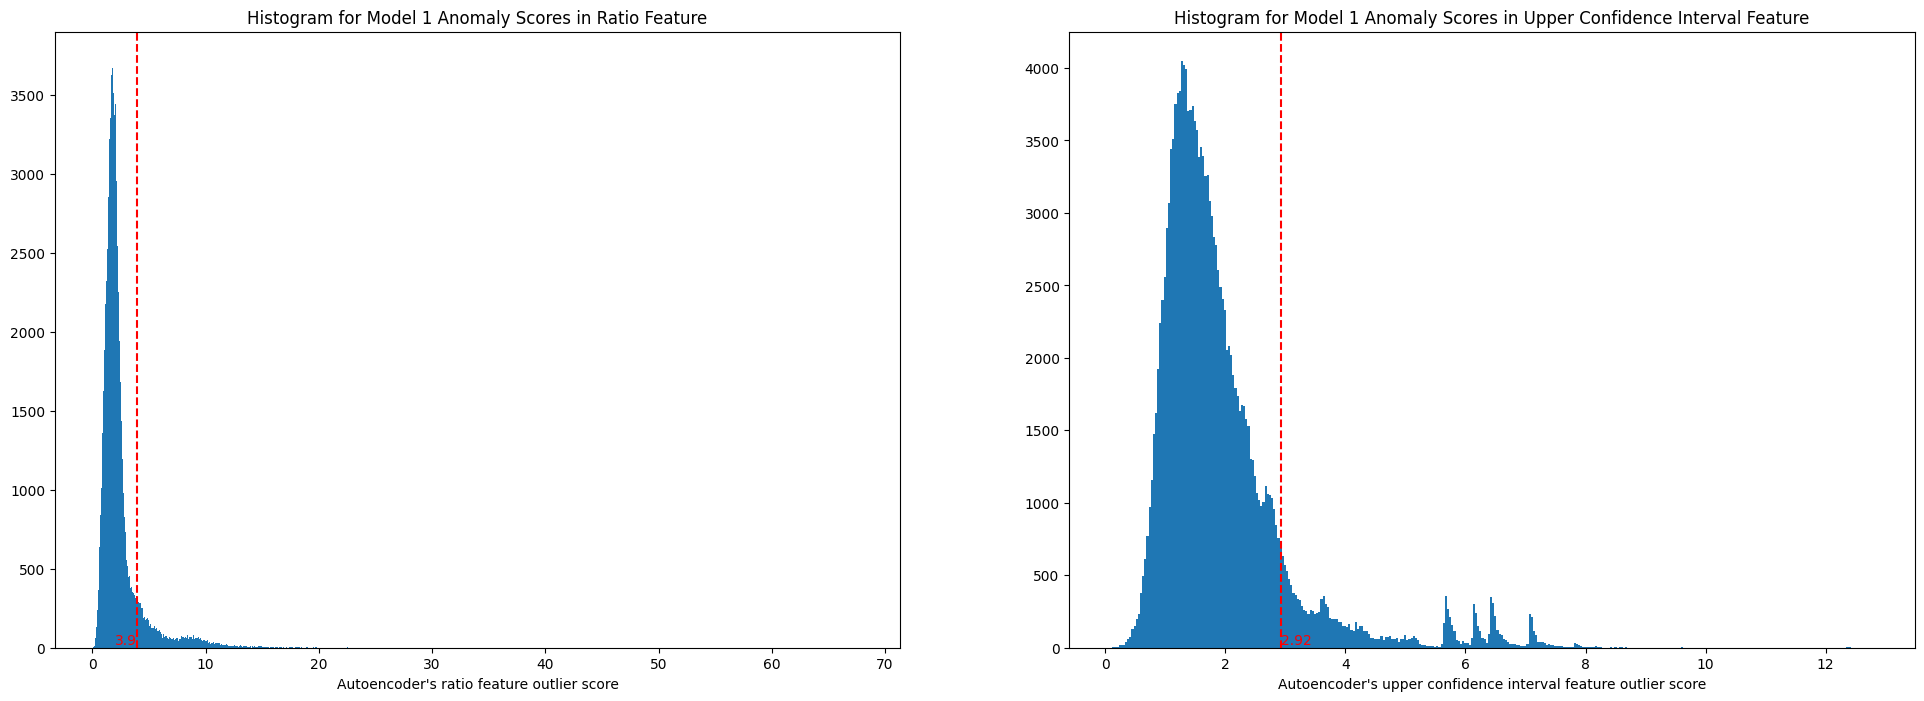

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_scores, bins='auto')
ax1.set_title("Histogram for Model 1 Anomaly Scores in Ratio Feature")
ax1.set_xlabel("Autoencoder's ratio feature outlier score")
ax1.axvline(x=3.9, color='red', linestyle='--')
ax1.text(3.9, 0, "3.9", ha='right', va='bottom', color='red')

ax2.hist(u_scores, bins='auto')
ax2.set_title("Histogram for Model 1 Anomaly Scores in Upper Confidence Interval Feature")
ax2.set_xlabel("Autoencoder's upper confidence interval feature outlier score")
ax2.axvline(x=2.92, color='red', linestyle='--')
ax2.text(2.92, 0, "2.92", ha='left', va='bottom', color='red')

plt.show()

Both figures above present the outlier scores. The histogram of ratio feature on the left, which the optimal threshold can be 3.9 and if the values are greater than this benchmark, they are outliers. The right-hand side graph is the histogram of upper confidence interval feature, which the benchmark line is suggested as 2.92. The values that greater than this could be treated as outliers.

In [33]:
#ratio
threshold = clf1_r.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_ratio, r_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,7,8,9,Anomaly_Score
0,Normal,146758,89.999693,-0.16,-0.16,-0.16,-0.16,-0.20,-0.20,-0.21,-0.20,-0.18,-0.18,1.88
1,Outlier,16307,10.000307,1.44,1.44,1.41,1.41,1.81,1.81,1.90,1.81,1.61,1.61,6.36


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


The outliers of the ratio feature occupy roughly 10% of the dataset with a low anomaly score 6.36, which means the observation within a dataset slightly deviates from the expected pattern. The average anomaly scores in the outlier group are all greater than those in the normal group. Especially feature 6 has the highest mean score, which is 'Total Discharges over mean average total payments' feature. This is because this feature might have a higher variance or wider range of values compared to other features.

In [34]:
#upper confidence interval feature
threshold = clf1_u.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_upper, u_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,Anomaly_Score
0,Normal,146758,89.999693,-0.17,-0.17,-0.12,0.06,-0.12,1.59
1,Outlier,16307,10.000307,1.50,1.50,1.06,-0.54,1.09,4.44


The outliers of the upper confidence interval feature occupy nearly 10% of the dataset with a lower anomaly score 4.44 comparing to ratio feature, which also shows that the observations have a slight deviation from the pattern established by the majority of the data points. The average anomaly scores in the outlier group are mostly greater than those in the normal group. Besides feature 3 has the lowest mean score amongst them, which is 'Total Discharges over 95% of Average Total Payments' feature. This feature in the outlier group has the lowest mean anomaly score could due to low variance, values are in a regular or predictable pattern, or it has multicollinearity phenomenon.

#### Model 2
* clf2 has hidden_neurons = [25, 10, 2, 10, 25]

**Ratio Feature**

In [96]:
#previous dataframe has Group and Anomaly string values included so I need to clean the dataset by dropping those values
datasets = [feature_ratio, feature_upper]

for dataset in datasets:
    if 'Group' in dataset.columns:
        dataset.drop('Group', axis=1, inplace=True)
    if 'Anomaly_Score' in dataset.columns:
        dataset.drop('Anomaly_Score', axis=1, inplace=True)

**Ratio Feature**

In [ ]:
#ratio feature
clf2_r = AutoEncoder(hidden_neurons = [25, 10, 2, 10, 25])
clf2_r.fit(feature_ratio)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 10)                110       
                                                                 
 dropout_12 (Dropout)        (None, 10)                0         
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
 dropout_13 (Dropout)        (None, 10)                0         
                                                                 
 dense_16 (Dense)            (None, 25)                275       
                                                                 
 dropout_14 (Dropout)        (None, 25)                0         
                                                                 
 dense_17 (Dense)            (None, 10)               

**Upper Confidence Interval Feature**

In [80]:
#previous dataframe has Group and Anomaly string values included so I need to clean the dataset by dropping those values
datasets = [feature_ratio, feature_upper]

for dataset in datasets:
    if 'Group' in dataset.columns:
        dataset.drop('Group', axis=1, inplace=True)
    if 'Anomaly_Score' in dataset.columns:
        dataset.drop('Anomaly_Score', axis=1, inplace=True)

In [ ]:
#upper feature
clf2_u = AutoEncoder(hidden_neurons = [25, 10, 2, 10, 25])
clf2_u.fit(feature_upper)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 5)                 30        
                                                                 
 dropout_53 (Dropout)        (None, 5)                 0         
                                                                 
 dense_61 (Dense)            (None, 5)                 30        
                                                                 
 dropout_54 (Dropout)        (None, 5)                 0         
                                                                 
 dense_62 (Dense)            (None, 25)                150       
                                                                 
 dropout_55 (Dropout)        (None, 25)                0         
                                                                 
 dense_63 (Dense)            (None, 10)               

##### Outlier Score

In [97]:
r_scores = clf2_r.decision_function(feature_ratio)
r_pred = clf2_r.predict(feature_ratio)

u_scores = clf2_u.decision_function(feature_upper)
u_pred = clf2_u.predict(feature_upper)
print({'ratio outlier scores': r_scores, 'upper confidence interval outlier scores': u_scores})
print({'ratio prediction': r_pred, 'upper confidence interval prediction': u_pred})


5096/5096 [==============================] - 8s 2ms/step
{'ratio outlier scores': array([1.33397136, 1.2841669 , 1.73915499, ..., 2.35498851, 5.86298419,
       2.98534025]), 'upper confidence interval outlier scores': array([2.67155239, 2.0317469 , 1.59261797, ..., 1.22504001, 1.2570732 ,
       1.73977391])}
{'ratio prediction': array([0, 0, 0, ..., 0, 1, 0]), 'upper confidence interval prediction': array([2.67155239, 2.0317469 , 1.59261797, ..., 1.22504001, 1.2570732 ,
       1.73977391])}


In [98]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The ratio data:", count_stat(r_pred))
print("The threshold for the defined contamination rate:" , clf2_r.threshold_)

The ratio data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 4.241750631594574


In [99]:
def print_dict_head(d, n=5):
    # create an iterator of key-value pairs and convert to list
    items = list(d.items())
    # print the first n items
    for k, v in items[:n]:
        print(f'{k}: {v}')

u_pred_stats = count_stat(u_pred)
print("The upper confidence interval data:")
print_dict_head(u_pred_stats)

print("The threshold for the defined contamination rate:", clf2_u.threshold_)


The upper confidence interval data:
0.04098576327245369: 1
0.10325729138121306: 1
0.11768017499573111: 1
0.12888140306484627: 1
0.14428011347945527: 1
The threshold for the defined contamination rate: 3.0060210891131875


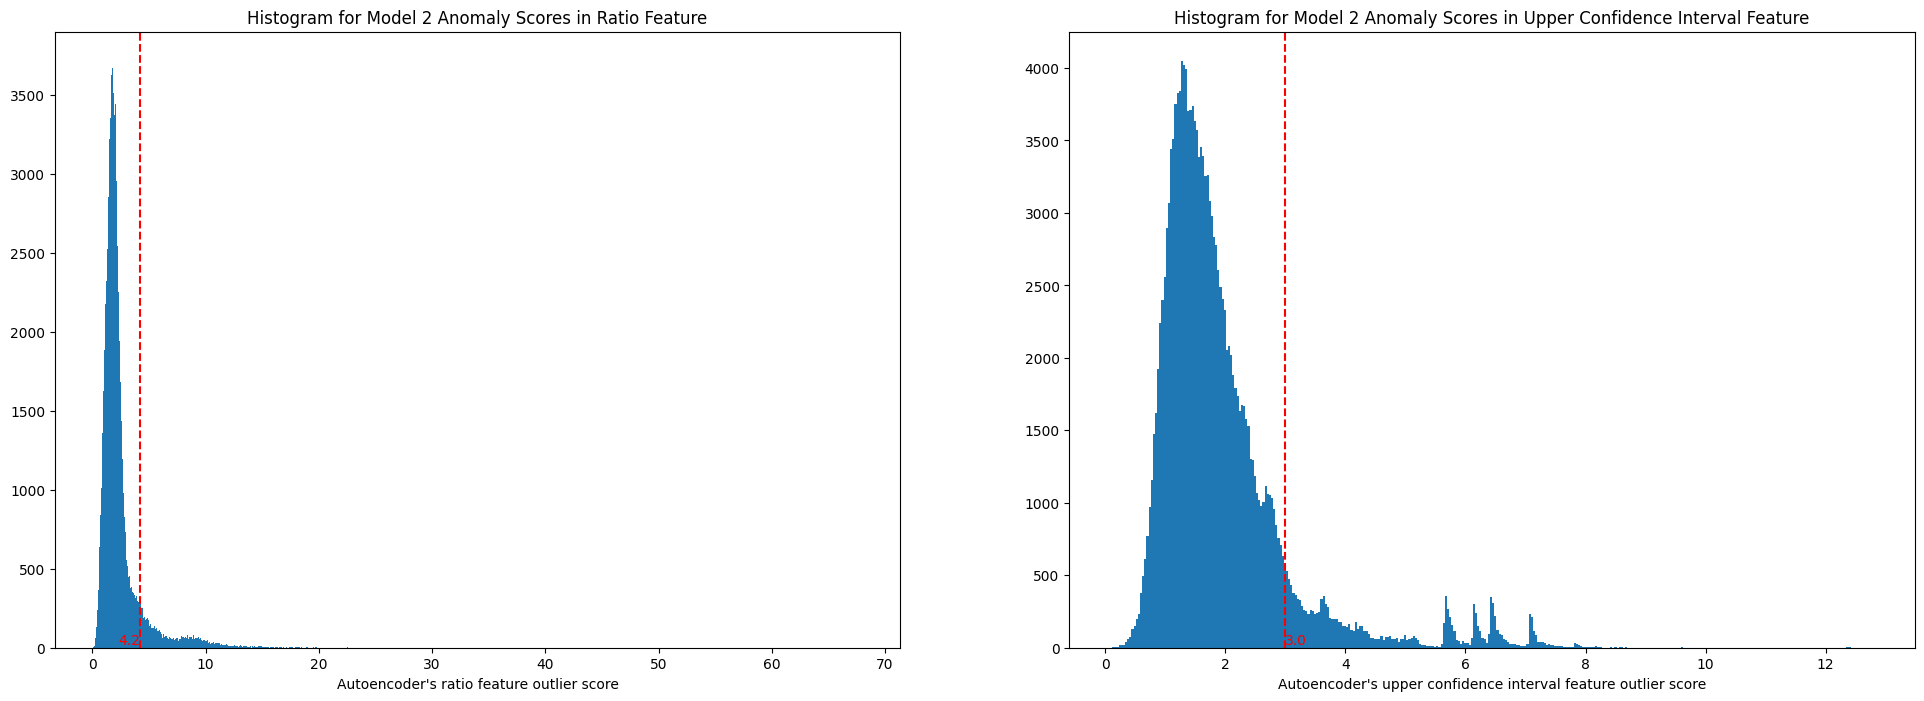

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_scores, bins='auto')
ax1.set_title("Histogram for Model 2 Anomaly Scores in Ratio Feature")
ax1.set_xlabel("Autoencoder's ratio feature outlier score")
ax1.axvline(x=4.2, color='red', linestyle='--')
ax1.text(4.2, 0, "4.2", ha='right', va='bottom', color='red')

ax2.hist(u_scores, bins='auto')
ax2.set_title("Histogram for Model 2 Anomaly Scores in Upper Confidence Interval Feature")
ax2.set_xlabel("Autoencoder's upper confidence interval feature outlier score")
ax2.axvline(x=3, color='red', linestyle='--')
ax2.text(3, 0, "3.0", ha='left', va='bottom', color='red')

plt.show()

Both figures above present the outlier scores. The histogram of ratio feature on the left, which the optimal threshold can be 4.2 and if the values are greater than this benchmark, they are outliers. The right-hand side graph is the histogram of upper confidence interval feature, which the benchmark line is suggested as 3. The values that greater than this could be treated as outliers.

In [101]:
#ratio
threshold = clf2_r.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_ratio, r_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,7,8,9,Anomaly_Score
0,Normal,146758,89.999693,-0.16,-0.16,-0.15,-0.15,-0.21,-0.21,-0.22,-0.21,-0.19,-0.19,1.9
1,Outlier,16307,10.000307,1.42,1.42,1.39,1.39,1.92,1.92,2.00,1.92,1.71,1.71,7.3


The outliers of the ratio feature occupy roughly 10% of the dataset with a low anomaly score 7.3, which means the observation within a dataset slightly deviates from the expected pattern. The average anomaly scores in the outlier group are all greaterer than those in the normal group. Especially feature 6 has the highest mean score, which is 'Total Discharges over mean average total payments' feature. This is because this feature might have a higher variance or wider range of values compared to other features.

In [102]:
#upper confidence interval feature
threshold = clf2_u.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_upper, u_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,Anomaly_Score
0,Normal,146758,89.999693,-0.17,-0.17,-0.13,0.05,-0.13,1.63
1,Outlier,16307,10.000307,1.54,1.54,1.14,-0.44,1.16,4.62


The outliers of the upper confidence interval feature occupy nearly 10% of the dataset with a lower anomaly score 4.62 comparing to ratio feature, which also shows that the observations have a slight deviation from the pattern established by the majority of the data points. The average anomaly scores in the outlier group are mostly greaterer than those in the normal group. Besides feature 3 has the lowest mean score amongst them, which is 'Total Discharges over 95% of Average Total Payments' feature. This feature in the outlier group has the lowest mean anomaly score could due to low variance, values are in a regular or predictable pattern, or it has multicollinearity phenomenon.

#### Model 3
* clf3 has hidden_neurons = [25, 15, 10, 2, 10, 15, 25])

In [ ]:
#previous dataframe has Group and Anomaly string values included so I need to clean the dataset by dropping those values
datasets = [feature_ratio, feature_upper]

for dataset in datasets:
    if 'Group' in dataset.columns:
        dataset.drop('Group', axis=1, inplace=True)
    if 'Anomaly_Score' in dataset.columns:
        dataset.drop('Anomaly_Score', axis=1, inplace=True)

**Ratio Feature**

In [ ]:
#ratio feature
clf3_r = AutoEncoder(hidden_neurons = [25, 15, 10, 2, 10, 15, 25])
clf3_r.fit(feature_ratio)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                110       
                                                                 
 dropout_26 (Dropout)        (None, 10)                0         
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dropout_27 (Dropout)        (None, 10)                0         
                                                                 
 dense_32 (Dense)            (None, 25)                275       
                                                                 
 dropout_28 (Dropout)        (None, 25)                0         
                                                                 
 dense_33 (Dense)            (None, 15)               

**Upper Confidence Interval Feature**

In [104]:
#previous dataframe has Group and Anomaly string values included so I need to clean the dataset by dropping those values
datasets = [feature_ratio, feature_upper]

for dataset in datasets:
    if 'Group' in dataset.columns:
        dataset.drop('Group', axis=1, inplace=True)
    if 'Anomaly_Score' in dataset.columns:
        dataset.drop('Anomaly_Score', axis=1, inplace=True)

In [105]:
#upper feature
clf3_u = AutoEncoder(hidden_neurons = [25, 15, 10, 2, 10, 15, 25])
clf3_u.fit(feature_upper)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 5)                 30        
                                                                 
 dropout_60 (Dropout)        (None, 5)                 0         
                                                                 
 dense_69 (Dense)            (None, 5)                 30        
                                                                 
 dropout_61 (Dropout)        (None, 5)                 0         
                                                                 
 dense_70 (Dense)            (None, 25)                150       
                                                                 
 dropout_62 (Dropout)        (None, 25)                0         
                                                                 
 dense_71 (Dense)            (None, 15)               

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 15, 10, 2, 10, 15, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x790285ac6cb0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

##### Outlier Score

In [106]:
r_scores = clf3_r.decision_function(feature_ratio)
r_pred = clf3_r.predict(feature_ratio)

u_scores = clf3_u.decision_function(feature_upper)
u_pred = clf3_u.predict(feature_upper)
print({'ratio outlier scores': r_scores, 'upper confidence interval outlier scores': u_scores})
print({'ratio prediction': r_pred, 'upper confidence interval prediction': u_pred})


5096/5096 [==============================] - 7s 1ms/step
{'ratio outlier scores': array([1.33347763, 1.28371109, 1.73865248, ..., 2.35478195, 5.42698867,
       2.98484306]), 'upper confidence interval outlier scores': array([2.67140045, 2.03183404, 1.59278403, ..., 1.22522912, 1.25730223,
       1.73992922])}
{'ratio prediction': array([0, 0, 0, ..., 0, 1, 0]), 'upper confidence interval prediction': array([0, 0, 0, ..., 0, 0, 0])}


In [107]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The ratio data:", count_stat(r_pred))
print("The threshold for the defined contamination rate:" , clf3_r.threshold_)

The ratio data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 3.8956276802164997


In [108]:
def print_dict_head(d, n=5):
    # create an iterator of key-value pairs and convert to list
    items = list(d.items())
    # print the first n items
    for k, v in items[:n]:
        print(f'{k}: {v}')

u_pred_stats = count_stat(u_pred)
print("The upper confidence interval data:")
print_dict_head(u_pred_stats)

print("The threshold for the defined contamination rate:", clf3_u.threshold_)


The upper confidence interval data:
0: 146758
1: 16307
The threshold for the defined contamination rate: 3.0059032900724767


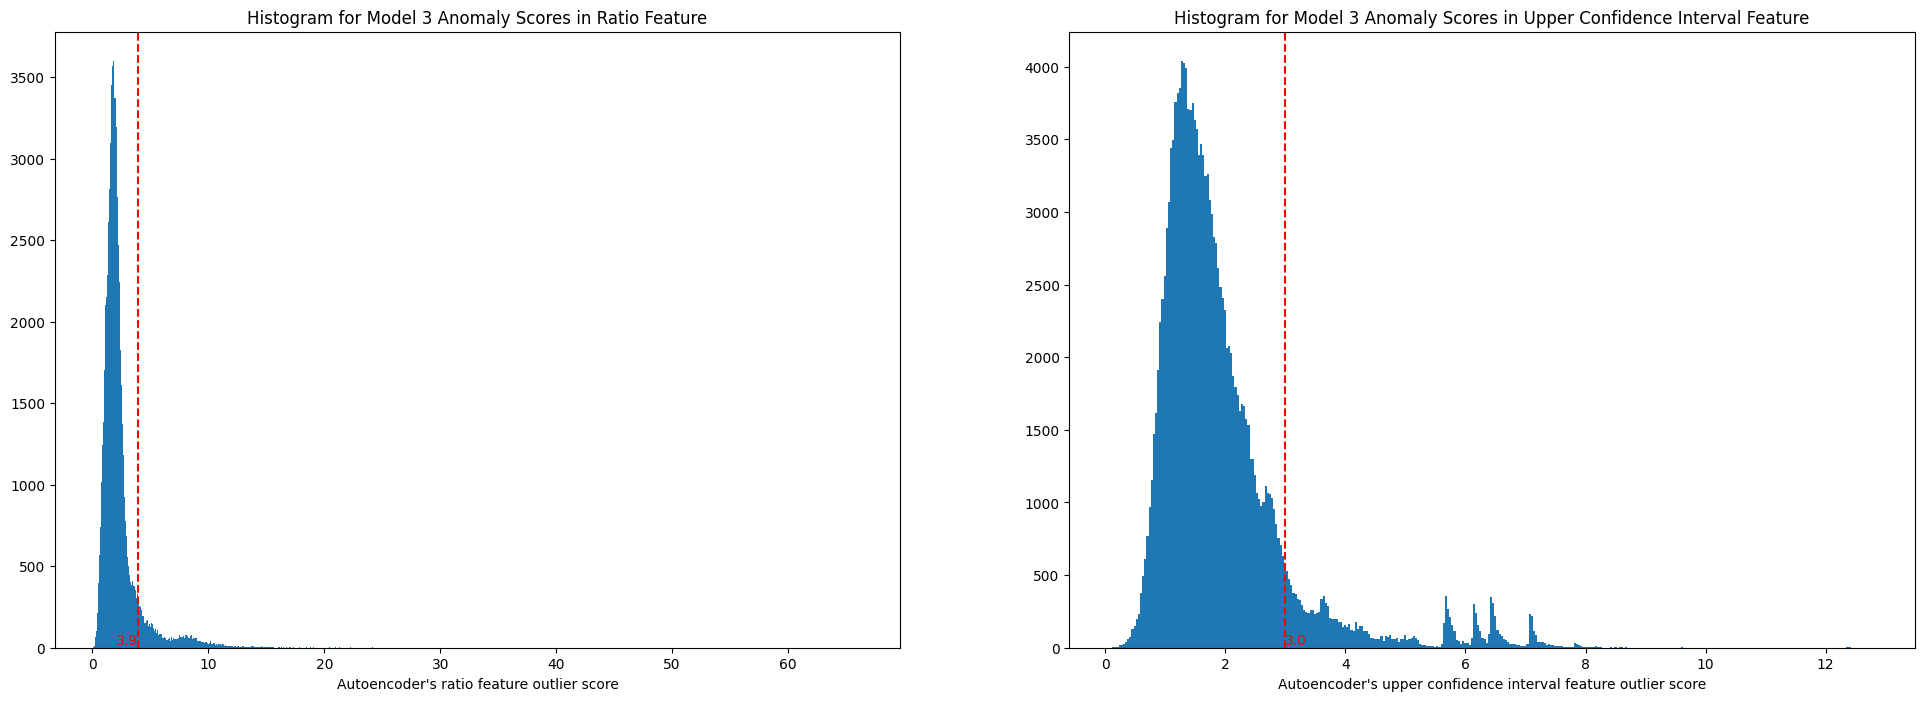

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_scores, bins='auto')
ax1.set_title("Histogram for Model 3 Anomaly Scores in Ratio Feature")
ax1.set_xlabel("Autoencoder's ratio feature outlier score")
ax1.axvline(x=3.9, color='red', linestyle='--')
ax1.text(3.9, 0, "3.9", ha='right', va='bottom', color='red')

ax2.hist(u_scores, bins='auto')
ax2.set_title("Histogram for Model 3 Anomaly Scores in Upper Confidence Interval Feature")
ax2.set_xlabel("Autoencoder's upper confidence interval feature outlier score")
ax2.axvline(x=3, color='red', linestyle='--')
ax2.text(3, 0, "3.0", ha='left', va='bottom', color='red')

plt.show()

Both figures above present the outlier scores. The histogram of ratio feature on the left, which the optimal threshold can be 3.9 and if the values are greater than this benchmark, they are outliers. The right-hand side graph is the histogram of upper confidence interval feature, which the benchmark line is suggested as 3. The values that greater than this could be treated as outliers.

In [110]:
#ratio
threshold = clf3_r.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_ratio, r_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,7,8,9,Anomaly_Score
0,Normal,146758,89.999693,-0.16,-0.16,-0.15,-0.15,-0.20,-0.20,-0.21,-0.20,-0.18,-0.18,1.87
1,Outlier,16307,10.000307,1.41,1.41,1.38,1.38,1.83,1.83,1.91,1.83,1.64,1.64,6.67


The outliers of the ratio feature occupy roughly 10% of the dataset with a low anomaly score 6.67, which means the observation within a dataset slightly deviates from the expected pattern. The average anomaly scores in the outlier group are all greaterer than those in the normal group. Especially feature 6 has the highest mean score, which is 'Total Discharges over mean average total payments' feature. This is because this feature might have a higher variance or wider range of values compared to other features.

In [111]:
#upper confidence interval feature
threshold = clf3_u.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_upper, u_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,Anomaly_Score
0,Normal,146758,89.999693,-0.17,-0.17,-0.13,0.05,-0.13,1.63
1,Outlier,16307,10.000307,1.54,1.54,1.14,-0.44,1.16,4.62


The outliers of the upper confidence interval feature occupy nearly 10% of the dataset with a lower anomaly score 4.62 comparing to ratio feature, which also shows that the observations have a slight deviation from the pattern established by the majority of the data points. The average anomaly scores in the outlier group are mostly greaterer than those in the normal group. Besides feature 3 has the lowest mean score amongst them, which is 'Total Discharges over 95% of Average Total Payments' feature. This feature in the outlier group has the lowest mean anomaly score could due to low variance, values are in a regular or predictable pattern, or it has multicollinearity phenomenon.

In [112]:
#Compare the scores
scores = pd.DataFrame({
    'Feature': ['Ratio', 'Upper Confidence Interval'],
    'clf1': [clf1_r.decision_scores_, clf1_u.decision_scores_],
    'clf2': [clf2_r.decision_scores_, clf2_u.decision_scores_],
    'clf3': [clf3_r.decision_scores_, clf3_u.decision_scores_]
})
scores

,Feature,clf1,clf2,clf3
0,Ratio,"[1.3334837909623733, 1.2837170337611628, 1.738...","[1.3339713612311033, 1.284166901616168, 1.7391...","[1.333477629596138, 1.283711092636367, 1.73865..."
1,Upper Confidence Interval,"[2.6707399171970114, 2.0308260913577203, 1.591...","[2.671552390309769, 2.031746899604251, 1.59261...","[2.671400447645642, 2.0318340369310914, 1.5927..."


In [113]:
r_scores_norm = StandardScaler().fit_transform(np.array(r_scores).reshape(-1, 1))
u_scores_norm = StandardScaler().fit_transform(np.array(u_scores).reshape(-1, 1))

#### Average
The "average" function in PyOD averages the outlier scores from multiple estimators.

In [114]:
#!pip install combo
from pyod.models.combination import aom, moa, average, maximization

In [115]:
# Combination by average
# ratio feature average
r_by_average = average(r_scores_norm) #average scores of all detectors

# upper confidence interval feature average
u_by_average = average(u_scores_norm)

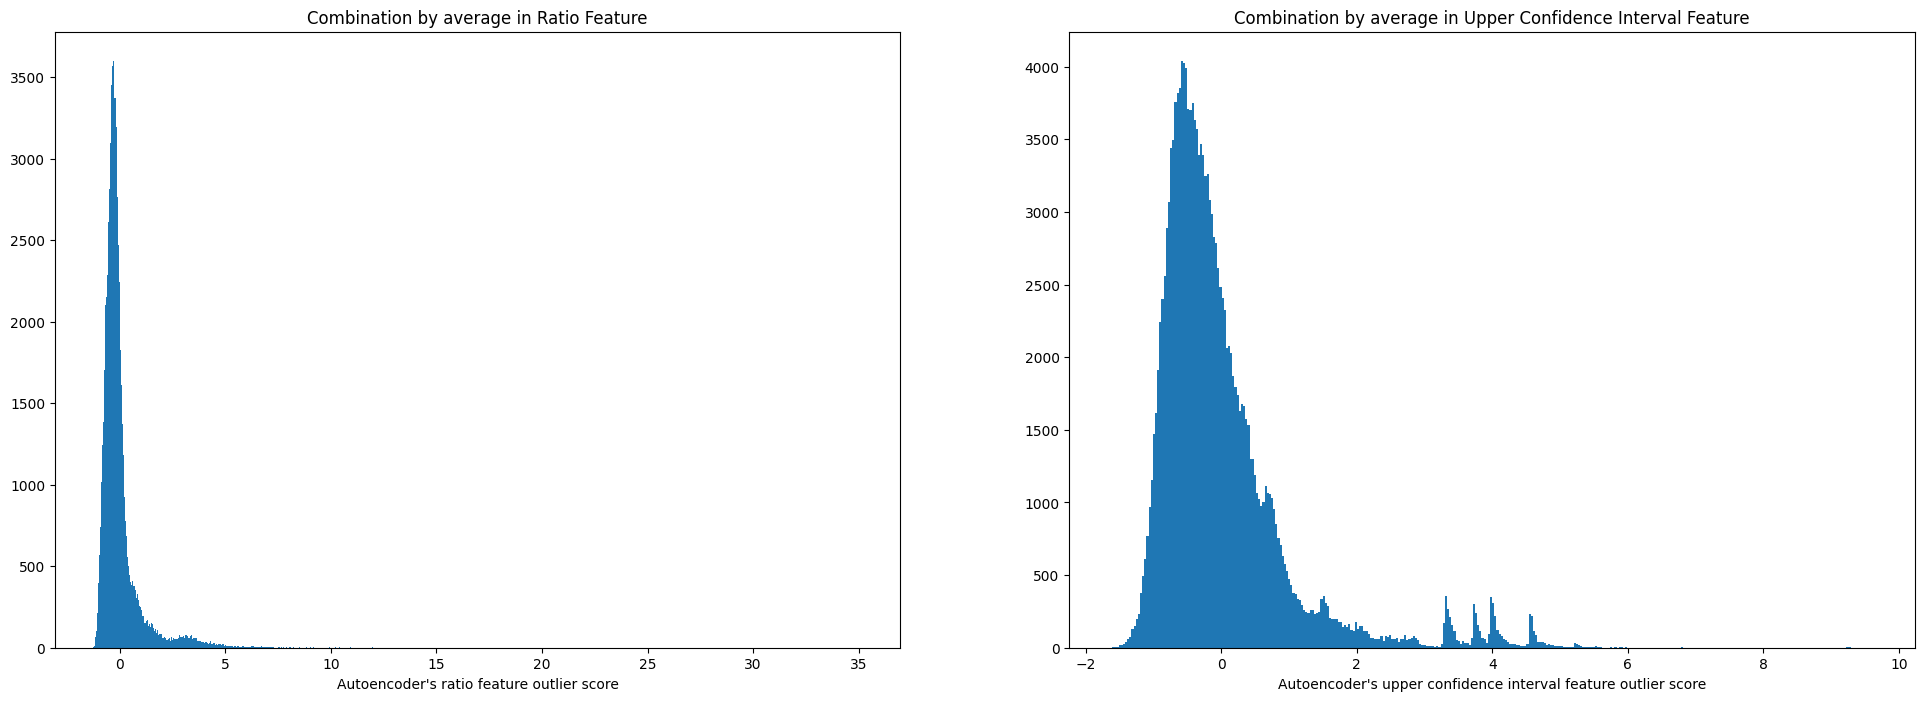

In [116]:
#plot histogram of the combination of average
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_by_average, bins='auto')
ax1.set_title("Combination by average in Ratio Feature")
ax1.set_xlabel("Autoencoder's ratio feature outlier score")

ax2.hist(u_by_average, bins='auto')
ax2.set_title("Combination by average in Upper Confidence Interval Feature")
ax2.set_xlabel("Autoencoder's upper confidence interval feature outlier score")

plt.show()

The combination by average graphs are similar as the Outlier scores charts above

##### Describe the outliers

In [117]:
# ratio feature identifies the outliers
df_r = pd.DataFrame(feature_ratio)
df_r['r_by_average_score'] = r_by_average
df_r['r_by_average_cluster'] = np.where(df_r['r_by_average_score']<0, 0, 1)

df_r.groupby('r_by_average_cluster').mean()

<ipython-input-117-8c377bbf189e>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,0,1,2,3,4,5,6,7,8,9,Anomaly_Score,r_by_average_score
r_by_average_cluster,,,,,,,,,,,,
0,-0.236340,-0.236340,-0.196138,-0.196138,-0.263715,-0.263715,-0.279775,-0.263715,-0.233812,-0.233812,1.610796,-0.408558
1,0.578072,0.578072,0.479741,0.479741,0.645028,0.645028,0.684312,0.645028,0.571889,0.571889,4.174205,0.999307


The anomalous ratio cluster 6 has the highest mean anomaly score which is 'Total Discharges over mean average total payments' feature. This feature might have larger variation than other features or it has unexpected patterns.

In [120]:
# upper confidence interval feature identifies the outliers
df_u = pd.DataFrame(feature_upper)
df_u['u_by_average_score'] = u_by_average
df_u['u_by_average_cluster'] = np.where(df_u['u_by_average_score']<0, 0, 1)

df_u.groupby('u_by_average_cluster').mean()

<ipython-input-120-27353563341b>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,0,1,2,3,4,Anomaly_Score,u_by_average_score
u_by_average_cluster,,,,,,,
0,-0.218624,-0.218624,-0.203235,0.238086,-0.172230,1.346854,-0.516410
1,0.398937,0.398937,0.370855,-0.434451,0.314279,2.994081,0.942324


The anomaly cluster 3 in upper confidence interval has an unsual negative  score compared to others. This feature is 'Total Discharges over 95% of Average Total Payments' which means this data point may seem less anomalous than other clusters.

#### Maximum of maximum
Merge the outlier scores from multiple estimators by taking the maximum.

In [121]:
# Combination by max
# ratio feature maximization
r_by_maximization = maximization(r_scores_norm) #maximise scores of all detectors

# upper confidence interval feature maximization
u_by_maximization = maximization(u_scores_norm)

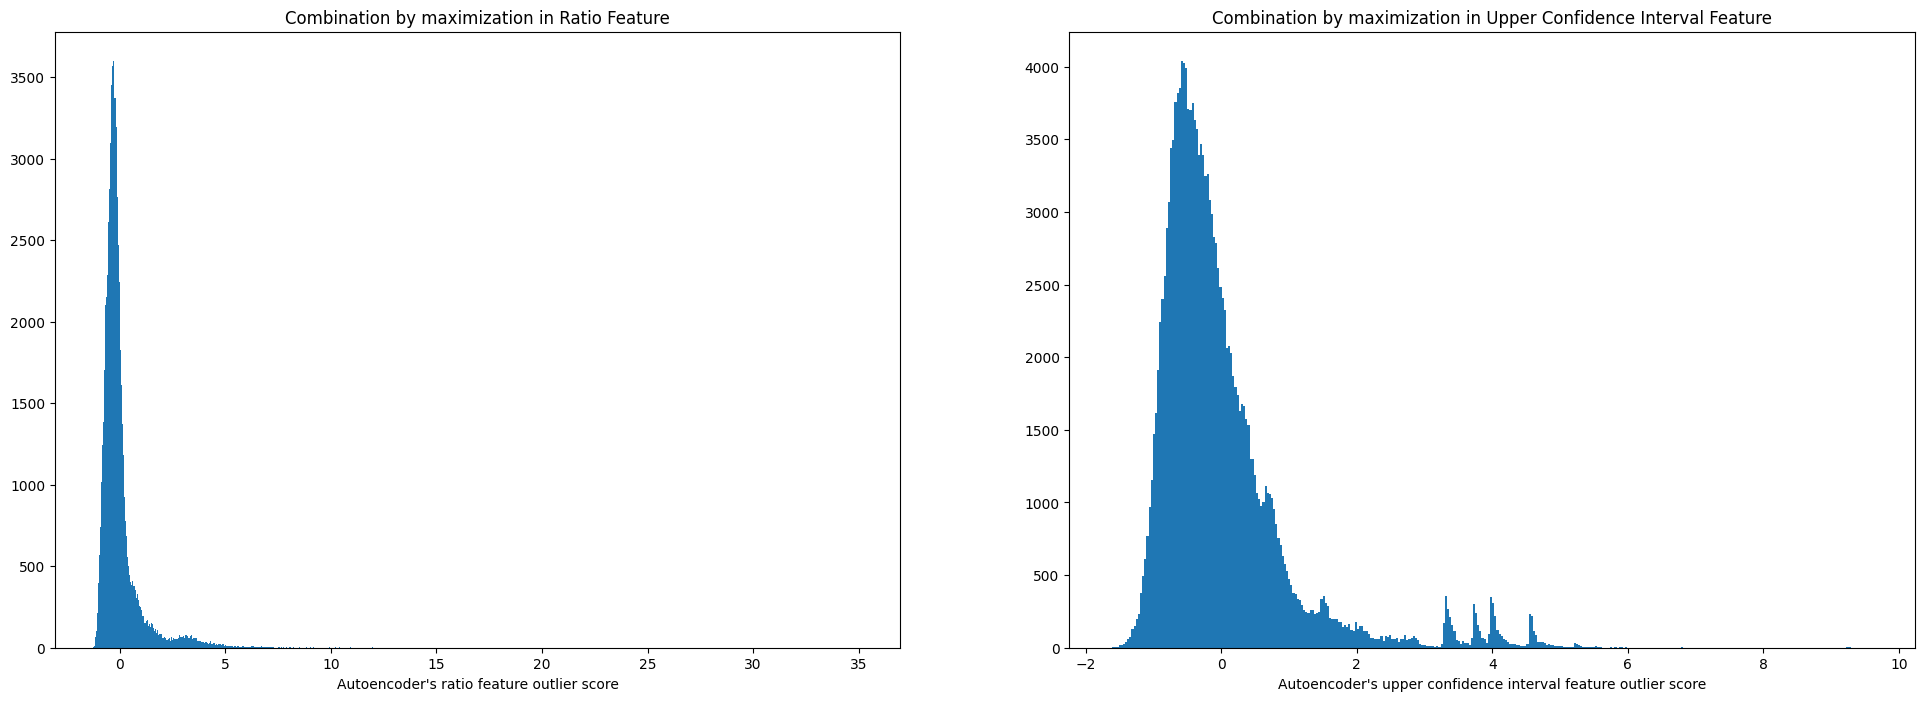

In [122]:
#plot histogram of the combination of maximization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_by_maximization, bins='auto')
ax1.set_title("Combination by maximization in Ratio Feature")
ax1.set_xlabel("Autoencoder's ratio feature outlier score")

ax2.hist(u_by_maximization, bins='auto')
ax2.set_title("Combination by maximization in Upper Confidence Interval Feature")
ax2.set_xlabel("Autoencoder's upper confidence interval feature outlier score")

plt.show()

##### Describe the outliers

In [123]:
# ratio feature identifies the outliers
df_r = pd.DataFrame(feature_ratio)
df_r['r_by_maximization_score'] = r_by_average
df_r['r_by_maximization_cluster'] = np.where(df_r['r_by_maximization_score']<0, 0, 1)

df_r.groupby('r_by_maximization_cluster').mean()

<ipython-input-123-f362378e6c5b>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,0,1,2,3,4,5,6,7,8,9,Anomaly_Score,r_by_average_score,r_by_average_cluster,r_by_maximization_score
r_by_maximization_cluster,,,,,,,,,,,,,,
0,-0.236340,-0.236340,-0.196138,-0.196138,-0.263715,-0.263715,-0.279775,-0.263715,-0.233812,-0.233812,1.610796,-0.408558,0.0,-0.408558
1,0.578072,0.578072,0.479741,0.479741,0.645028,0.645028,0.684312,0.645028,0.571889,0.571889,4.174205,0.999307,1.0,0.999307


In [125]:
# upper confidence interval feature identifies the outliers
df_u = pd.DataFrame(feature_upper)
df_u['u_by_maximization_score'] = u_by_maximization
df_u['u_by_maximization_cluster'] = np.where(df_u['u_by_maximization_score']<0, 0, 1)

df_u.groupby('u_by_maximization_cluster').mean()

<ipython-input-125-9b15ef1652cf>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,0,1,2,3,4,Anomaly_Score,u_by_average_score,u_by_average_cluster,u_by_maximization_score
u_by_maximization_cluster,,,,,,,,,
0,-0.218624,-0.218624,-0.203235,0.238086,-0.172230,1.346854,-0.516410,0.0,-0.516410
1,0.398937,0.398937,0.370855,-0.434451,0.314279,2.994081,0.942324,1.0,0.942324


Maximum of maximum method shares the same result as Average's summary statistics.

### Isolated Forest
1. Unsupervised anomaly detection method
2. The model does not use much memory because it does not measure any distance so it is usually adopted while having large dataset and high-dimensional problems
3. Isolates each observation using a tree structure so normal data typically hides deep in the tree, whereas anomalies will be the first to be identified.
4. Observations with short average path lengths on the iTrees are considered anomalies.

In [127]:
from pyod.models.iforest import IForest

#### Model 1
max_samples = 100

In [131]:
#previous dataframe has Group and Anomaly string values included so I need to clean the dataset again
feature_ratio = pd.concat([drg_avg['drg_avg_ratio'], med_drg['drg_median_ratio_amount'], drg_state_avg['drg_state_avg_ratio'], med_drg_state['drg_state_median_ratio_amount'],
    hos_region_avg['hos_region_avg_ratio'], med_hos['hos_median_ratio_amount'], dis_avg['dis_avg_ratio'], med_total_discharges['med_total_discharges_ratio_amount'],
    name_avg['name_avg_ratio'], med_name['med_hos_ratio_amount']], axis=1)

feature_ratio = StandardScaler().fit_transform(feature_ratio)
feature_ratio = pd.DataFrame(feature_ratio)

feature_upper = pd.concat([drg_95['upper_CI'], state_drg_95['upper_CI'], hos_region_95['upper_CI'], dis_95['upper_CI'], name_95['upper_CI']], axis=1)
feature_upper.columns = ['drg_upper', 'state_drg_upper', 'hos_region_upper', 'dis_upper', 'name_upper']
feature_upper = feature_upper.fillna(feature_upper.mean())
feature_upper = StandardScaler().fit_transform(feature_upper)
feature_upper = pd.DataFrame(feature_upper)



**Ratio Feature**

In [133]:
isft1 = IForest(behaviour="new", max_samples=100)
isft1.fit(feature_ratio)

r_scores = isft1.decision_function(feature_ratio)  # outlier scores
r_scores = pd.Series(r_scores)

r_pred = isft1.predict(feature_ratio)
r_pred = pd.Series(r_pred)
r_scores.head()

0   -0.161481
1   -0.158117
2   -0.155696
3   -0.155285
4   -0.158224
dtype: float64

In [134]:
# Threshold for the defined comtanimation rate
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The ratio data:", count_stat(r_pred))
print("The threshold for the defined contamination rate:" , isft1.threshold_)

The ratio data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 6.477324475124679e-17


**Importance of Variable**

<Axes: >

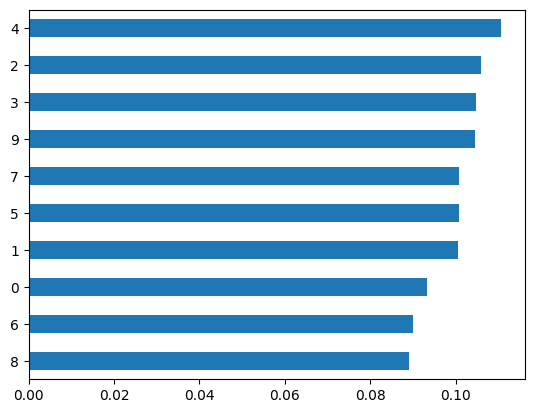

In [136]:
isft1_r = isft1.feature_importances_

for_plot = pd.DataFrame({'x_axis':feature_ratio.columns,
              'y_axis':isft1_r}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

Top 3 important ratio features in IForest model 1 are feature 4, 2, and 3, which determine the outliers with relative strength. These features are followed as 'Hospital_referral_region_desp's Average Total Payment', 'State & DRG's Average Payment', and 'State and DRG's of Median Average Total Payment'.

##### Summary Statistics - Ratio

In [137]:
threshold = isft1.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_ratio, r_scores,threshold)


,Group,Count,Count %,0,1,2,3,4,5,6,7,8,9,Anomaly_Score
0,Normal,146758,89.999693,-0.13,-0.13,-0.13,-0.13,-0.24,-0.24,-0.24,-0.24,-0.22,-0.22,-0.13
1,Outlier,16307,10.000307,1.15,1.15,1.13,1.13,2.13,2.13,2.17,2.13,1.95,1.95,0.08


The outliers of the ratio feature occupy roughly 10% of the dataset with a very low anomaly score 0.08, which means the observation within a dataset slightly deviates from the expected pattern. The average anomaly scores in the outlier group are all greater than those in the normal group. Especially feature 6 has the highest mean score, which is 'Total Discharges over mean average total payments' feature. This is because this feature might have a higher variance or wider range of values compared to other features.

**Upper Confidence Interval Feature**

In [138]:
isft1 = IForest(behaviour="new", max_samples=100)
isft1.fit(feature_upper)

u_scores = isft1.decision_function(feature_upper)  # outlier scores
u_scores = pd.Series(u_scores)

u_pred = isft1.predict(feature_upper)
u_pred = pd.Series(u_pred)

In [139]:
# Threshold for the defined comtanimation rate
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#upper
print("The upper confidence interval data:", count_stat(u_pred))
print("The threshold for the defined contamination rate:" , isft1.threshold_)

The upper confidence interval data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 2.7278060791614302e-17


**Importance of Variable**

<Axes: >

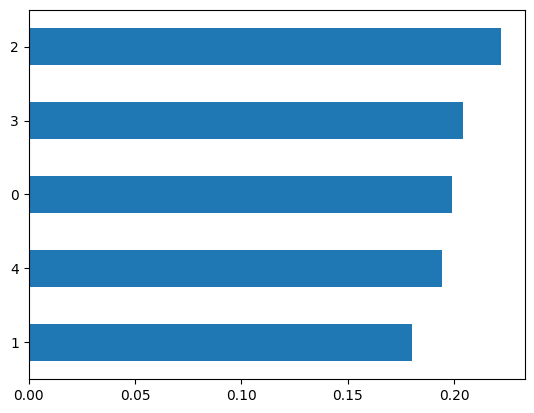

In [140]:
isft1_u = isft1.feature_importances_

for_plot = pd.DataFrame({'x_axis':feature_upper.columns,
              'y_axis':isft1_u}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

Top 3 important upper features in IForest model 1 are feature 2, 3, and 0, which determine the outliers with relative strength. These features are followed as 'Hospital_referral_region_desp's 95% CI of Average Total Payment', 'Total Discharges over 95% of Average Total Payments', and 'DRG's 95% CI of Average Payment'.

##### Summary Statistics - Upper

In [141]:
threshold = isft1.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_upper, u_scores,threshold)


,Group,Count,Count %,0,1,2,3,4,Anomaly_Score
0,Normal,146758,89.999693,-0.21,-0.21,-0.11,0.02,-0.12,-0.11
1,Outlier,16307,10.000307,1.87,1.87,1.00,-0.20,1.05,0.06


The outliers of the upper confidence interval feature occupy nearly 10% of the dataset with a very low anomaly score 0.06 comparing to ratio feature, which also shows that the observations have a slight deviation from the pattern established by the majority of the data points. The average anomaly scores in the outlier group are mostly greater than those in the normal group. Besides feature 3 has the lowest mean score amongst them, which is 'Total Discharges over 95% of Average Total Payments' feature. This feature in the outlier group has the lowest mean anomaly score could due to low variance, values are in a regular or predictable pattern, or it has multicollinearity phenomenon.

**Plot the histogram**

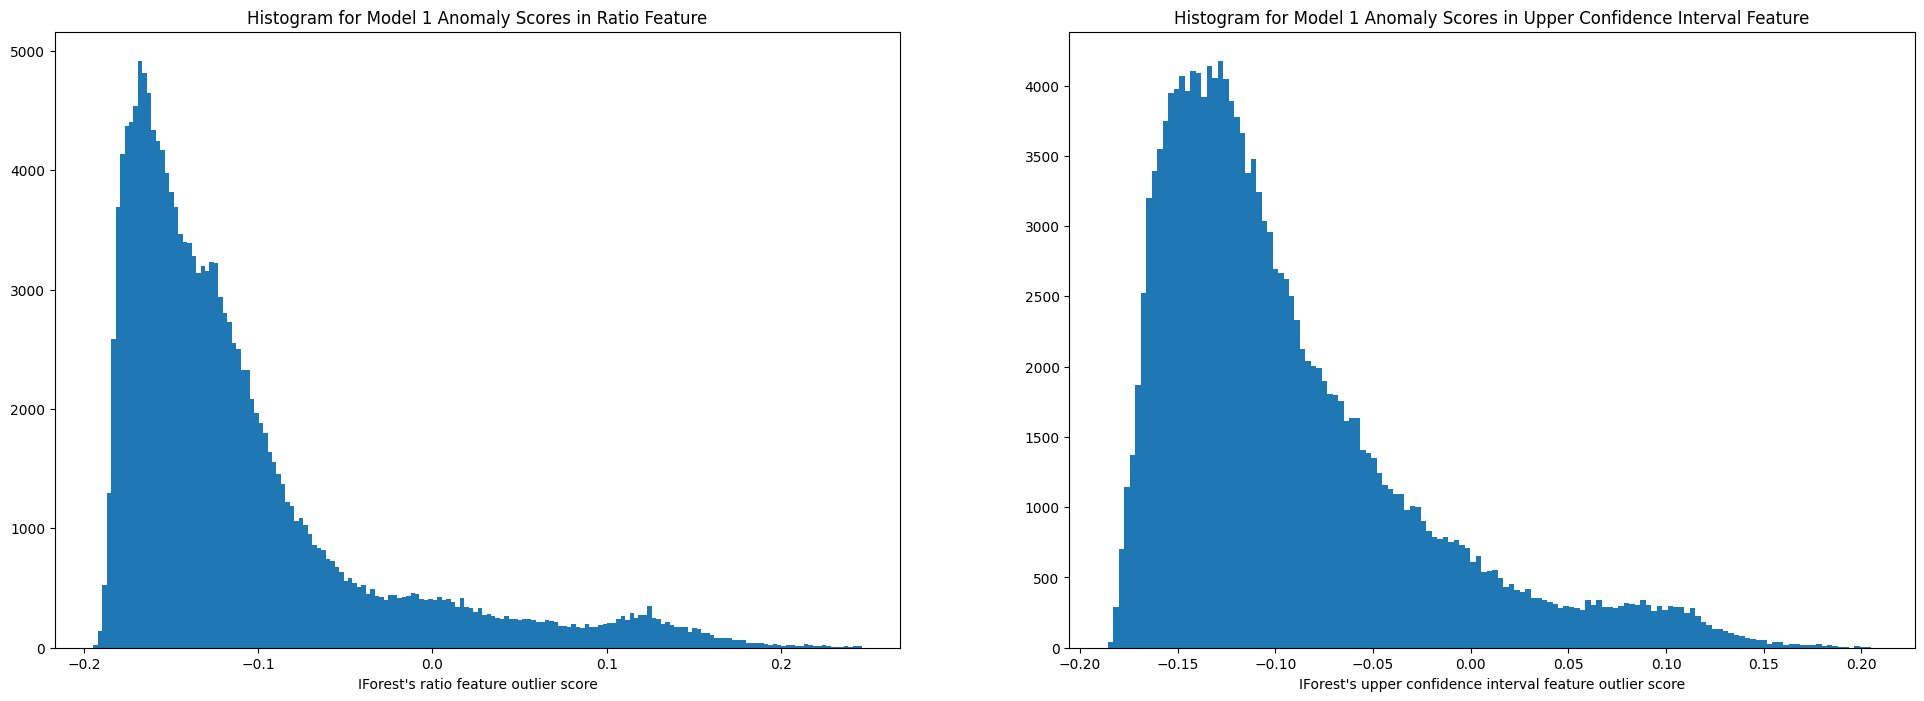

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_scores, bins='auto')
ax1.set_title("Histogram for Model 1 Anomaly Scores in Ratio Feature")
ax1.set_xlabel("IForest's ratio feature outlier score")

ax2.hist(u_scores, bins='auto')
ax2.set_title("Histogram for Model 1 Anomaly Scores in Upper Confidence Interval Feature")
ax2.set_xlabel("IForest's upper confidence interval feature outlier score")

plt.show()

Both graphs in ratio and upper confidence interval features present right-skewed distribution. If we set the anomaly benchmark as 0, the scores that are greater than 0 are treated as outliers.

#### Model 2
max_samples = 80

In [144]:
#previous dataframe has Group and Anomaly string values included so I need to clean the dataset by dropping those values
datasets = [feature_ratio, feature_upper]

for dataset in datasets:
    if 'Group' in dataset.columns:
        dataset.drop('Group', axis=1, inplace=True)
    if 'Anomaly_Score' in dataset.columns:
        dataset.drop('Anomaly_Score', axis=1, inplace=True)

**Ratio Feature**

In [145]:
isft2 = IForest(behaviour="new", max_samples=80)
isft2.fit(feature_ratio)

r_scores = isft2.decision_function(feature_ratio)  # outlier scores
r_scores = pd.Series(r_scores)

r_pred = isft2.predict(feature_ratio)
r_pred = pd.Series(r_pred)

In [146]:
# Threshold for the defined comtanimation rate
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The ratio data:", count_stat(r_pred))
print("The threshold for the defined contamination rate:" , isft2.threshold_)

The ratio data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 5.622604703874046e-17


**Importance of Variable**

<Axes: >

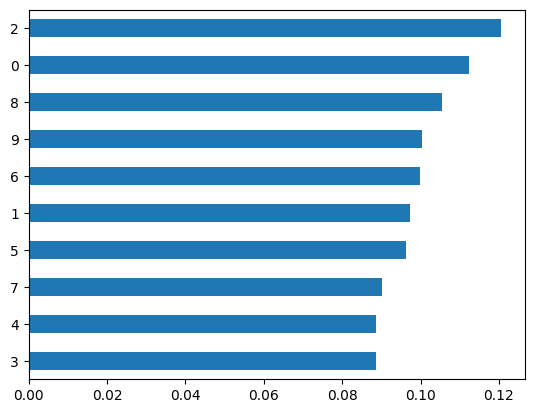

In [147]:
isft2_r = isft2.feature_importances_

for_plot = pd.DataFrame({'x_axis':feature_ratio.columns,
              'y_axis':isft2_r}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

Top 3 important ratio features in model 2 are feature 2, 0, and 8. These features are followed as 'State & DRG's Average Payment', 'DRG's of Average Payment', and 'Provider name's Mean Average Total Payment'.



##### Summary Statistics - Ratio

In [148]:
threshold = isft2.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_ratio, r_scores, threshold)


,Group,Count,Count %,0,1,2,3,4,5,6,7,8,9,Anomaly_Score
0,Normal,146758,89.999693,-0.11,-0.11,-0.11,-0.11,-0.24,-0.24,-0.24,-0.24,-0.22,-0.22,-0.14
1,Outlier,16307,10.000307,1.03,1.03,1.01,1.01,2.17,2.17,2.20,2.17,2.02,2.02,0.07


The outliers of the ratio feature occupy roughly 10% of the dataset with a very low anomaly score 0.07, which means the observation within a dataset slightly deviates from the expected pattern. The average anomaly scores in the outlier group are all greaterer than those in the normal group. Especially feature 6 has the highest mean score, which is 'Total Discharges over mean average total payments' feature. This is because this feature might have a higher variance or wider range of values compared to other features.

**Upper Confidence Interval Feature**

In [149]:
isft2 = IForest(behaviour="new", max_samples=80)
isft2.fit(feature_upper)

u_scores = isft2.decision_function(feature_upper)  # outlier scores
u_scores = pd.Series(u_scores)

u_pred = isft2.predict(feature_upper)
u_pred = pd.Series(u_pred)

In [150]:
# Threshold for the defined comtanimation rate
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The upper confidence interval data:", count_stat(u_pred))
print("The threshold for the defined contamination rate:" , isft2.threshold_)

The upper confidence interval data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: -4.385867779455803e-17


**Importance of Variable**

<Axes: >

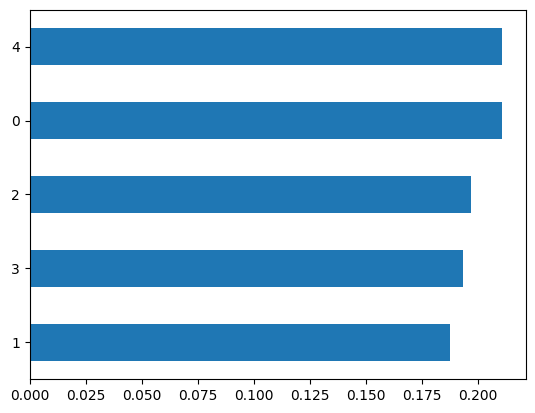

In [151]:
isft2_u = isft2.feature_importances_

for_plot = pd.DataFrame({'x_axis':feature_upper.columns,
              'y_axis':isft2_u}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

Top 3 important upper features in IForest model 1 are feature 4, 0, and 2, which determine the outliers with relative strength. These features are followed as 'Provider name's 95% CI of Average Total Payment', 'DRG's 95% CI of Average Payment', and 'Hospital_referral_region_desp's 95% CI of Average Total Payment'.

##### Summary Statistics - Upper

In [152]:
threshold = isft1.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_upper, u_scores, threshold)


,Group,Count,Count %,0,1,2,3,4,Anomaly_Score
0,Normal,146758,89.999693,-0.20,-0.20,-0.10,0.04,-0.12,-0.10
1,Outlier,16307,10.000307,1.82,1.82,0.94,-0.36,1.08,0.06


The outliers of the upper confidence interval feature occupy nearly 10% of the dataset with a very low anomaly score 0.06 comparing to ratio feature, which also shows that the observations have a slight deviation from the pattern established by the majority of the data points. The average anomaly scores in the outlier group are mostly greaterer than those in the normal group. Besides feature 3 has the lowest mean score amongst them, which is 'Total Discharges over 95% of Average Total Payments' feature. This feature in the outlier group has the lowest mean anomaly score could due to low variance, values are in a regular or predictable pattern, or it has multicollinearity phenomenon.

**Plot the histogram of outlier scores**

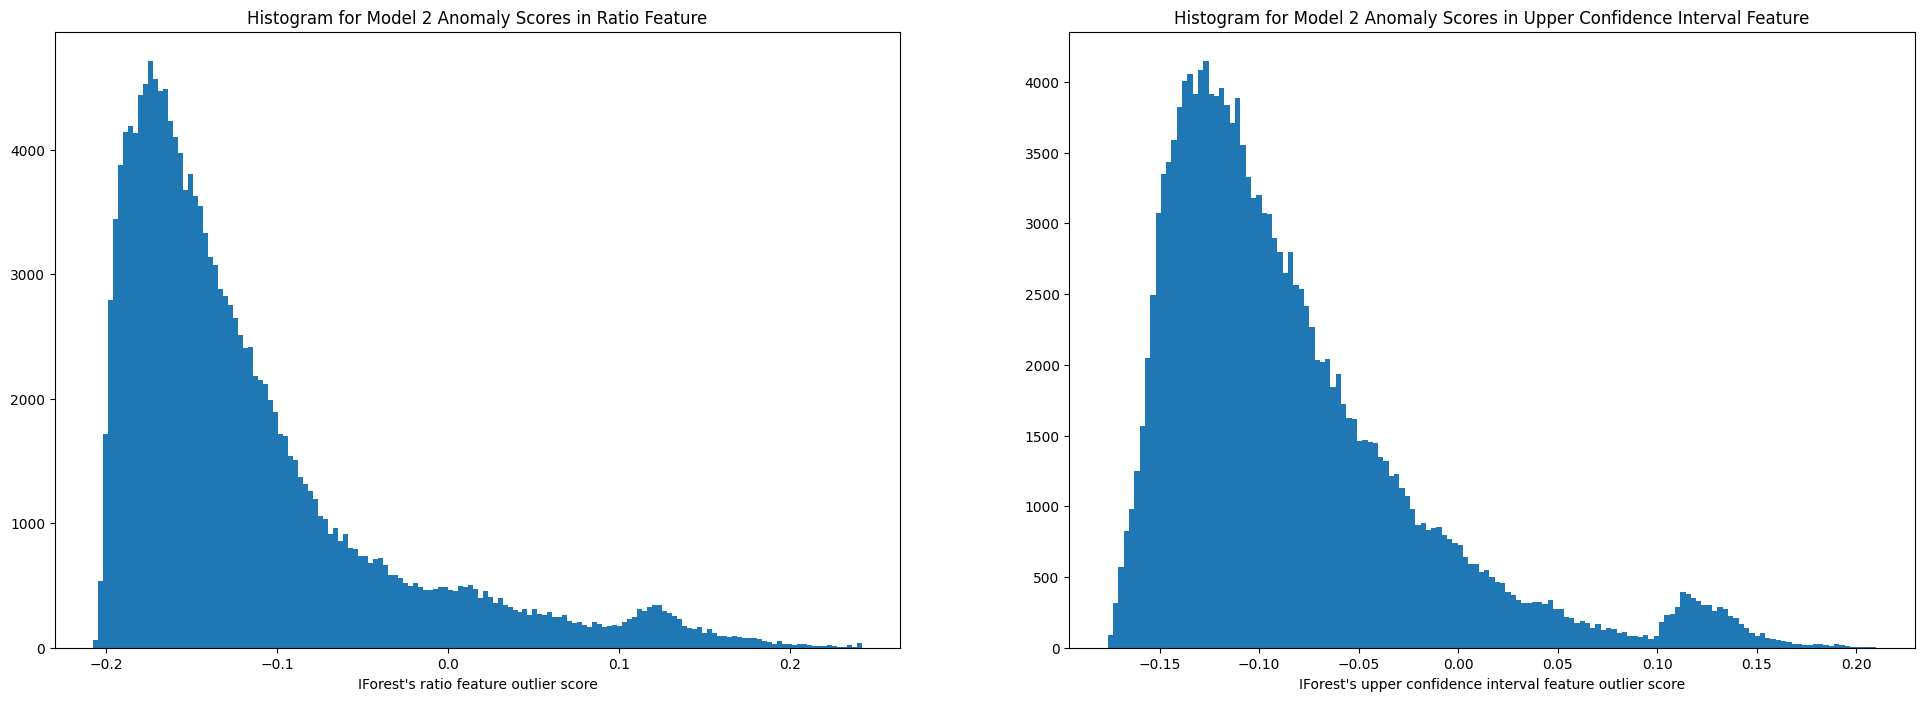

In [153]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_scores, bins='auto')
ax1.set_title("Histogram for Model 2 Anomaly Scores in Ratio Feature")
ax1.set_xlabel("IForest's ratio feature outlier score")

ax2.hist(u_scores, bins='auto')
ax2.set_title("Histogram for Model 2 Anomaly Scores in Upper Confidence Interval Feature")
ax2.set_xlabel("IForest's upper confidence interval feature outlier score")

plt.show()

Both graphs in ratio and upper confidence interval features present right-skewed distribution. If we set the anomaly benchmark as 0, the scores that are greater than 0 are treated as outliers.

#### Model 3
max_samples = 60

In [154]:
#previous dataframe has Group and Anomaly string values included so I need to clean the dataset by dropping those values
datasets = [feature_ratio, feature_upper]

for dataset in datasets:
    if 'Group' in dataset.columns:
        dataset.drop('Group', axis=1, inplace=True)
    if 'Anomaly_Score' in dataset.columns:
        dataset.drop('Anomaly_Score', axis=1, inplace=True)

**Ratio Feature**

In [155]:
isft3 = IForest(behaviour="new", max_samples=80)
isft3.fit(feature_ratio)

r_scores = isft3.decision_function(feature_ratio)  # outlier scores
r_scores = pd.Series(r_scores)

r_pred = isft3.predict(feature_ratio)
r_pred = pd.Series(r_pred)

In [156]:
# Threshold for the defined comtanimation rate
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The ratio data:", count_stat(r_pred))
print("The threshold for the defined contamination rate:" , isft3.threshold_)

The ratio data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 5.2741353493736265e-17


**Importance of Variable**

<Axes: >

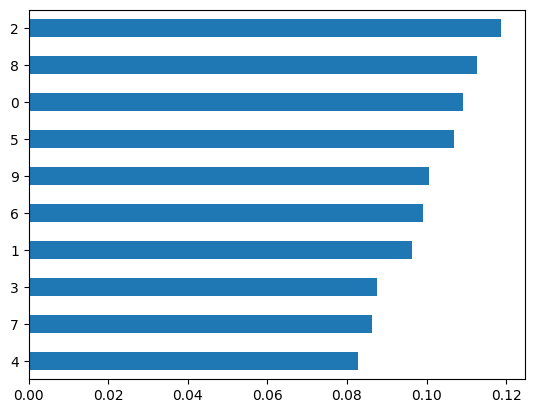

In [157]:
isft3_r = isft3.feature_importances_

for_plot = pd.DataFrame({'x_axis':feature_ratio.columns,
              'y_axis':isft3_r}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

Top 3 important ratio features in model 3 are feature 2, 8, and 0. These features are followed as 'State & DRG's Average Payment', 'Provider name's Mean Average Total Payment', and 'DRG's of Average Payment'.

##### Summary Statistics - Ratio

In [158]:
threshold = isft3.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_ratio, r_scores, threshold)


,Group,Count,Count %,0,1,2,3,4,5,6,7,8,9,Anomaly_Score
0,Normal,146758,89.999693,-0.13,-0.13,-0.13,-0.13,-0.23,-0.23,-0.24,-0.23,-0.21,-0.21,-0.14
1,Outlier,16307,10.000307,1.21,1.21,1.16,1.16,2.07,2.07,2.13,2.07,1.90,1.90,0.07


The outliers of the ratio feature occupy roughly 10% of the dataset with a very low anomaly score 0.07, which means the observation within a dataset slightly deviates from the expected pattern. The average anomaly scores in the outlier group are all greaterer than those in the normal group. Especially feature 6 has the highest mean score, which is 'Total Discharges over mean average total payments' feature. This is because this feature might have a higher variance or wider range of values compared to other features.

**Upper Confidence Interval Feature**

In [159]:
isft3 = IForest(behaviour="new", max_samples=80)
isft3.fit(feature_upper)

u_scores = isft3.decision_function(feature_upper)  # outlier scores
u_scores = pd.Series(u_scores)

u_pred = isft3.predict(feature_upper)
u_pred = pd.Series(u_pred)

In [160]:
# Threshold for the defined comtanimation rate
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

#ratio
print("The upper confidence interval data:", count_stat(u_pred))
print("The threshold for the defined contamination rate:" , isft3.threshold_)

The upper confidence interval data: {0: 146758, 1: 16307}
The threshold for the defined contamination rate: 2.632758394567657e-17


**Importance of Variable**

<Axes: >

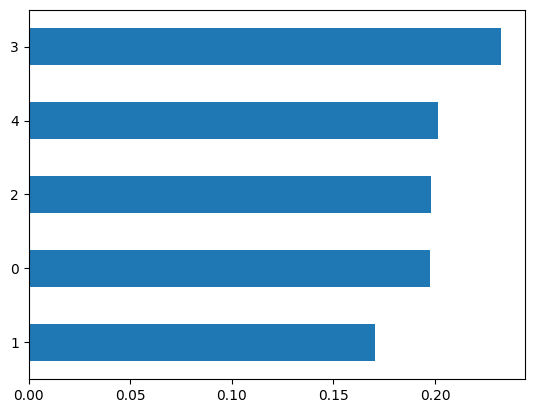

In [161]:
isft3_u = isft3.feature_importances_

for_plot = pd.DataFrame({'x_axis':feature_upper.columns,
              'y_axis':isft3_u}).sort_values(by='y_axis',ascending=True)
for_plot['y_axis'].plot.barh()

Top 3 important upper features in IForest model 1 are feature 3, 4, and 2, which determine the outliers with relative strength. These features are followed as 'Total Discharges over 95% of Average Total Payments', 'Provider name's 95% CI of Average Total Payment', and 'Hospital_referral_region_desp's 95% CI of Average Total Payment'.

##### Summary Statistics - Upper

In [162]:
threshold = isft3.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(feature_upper, u_scores, threshold)


,Group,Count,Count %,0,1,2,3,4,Anomaly_Score
0,Normal,146758,89.999693,-0.20,-0.20,-0.11,0.05,-0.12,-0.10
1,Outlier,16307,10.000307,1.76,1.76,0.96,-0.43,1.10,0.06


The outliers of the upper confidence interval feature occupy nearly 10% of the dataset with a very low anomaly score 0.06 comparing to ratio feature, which also shows that the observations have a slight deviation from the pattern established by the majority of the data points. The average anomaly scores in the outlier group are mostly greaterer than those in the normal group. Besides feature 3 has the lowest mean score amongst them, which is 'Total Discharges over 95% of Average Total Payments' feature. This feature in the outlier group has the lowest mean anomaly score could due to low variance, values are in a regular or predictable pattern, or it has multicollinearity phenomenon.

**Plot the histogram of outlier scores**

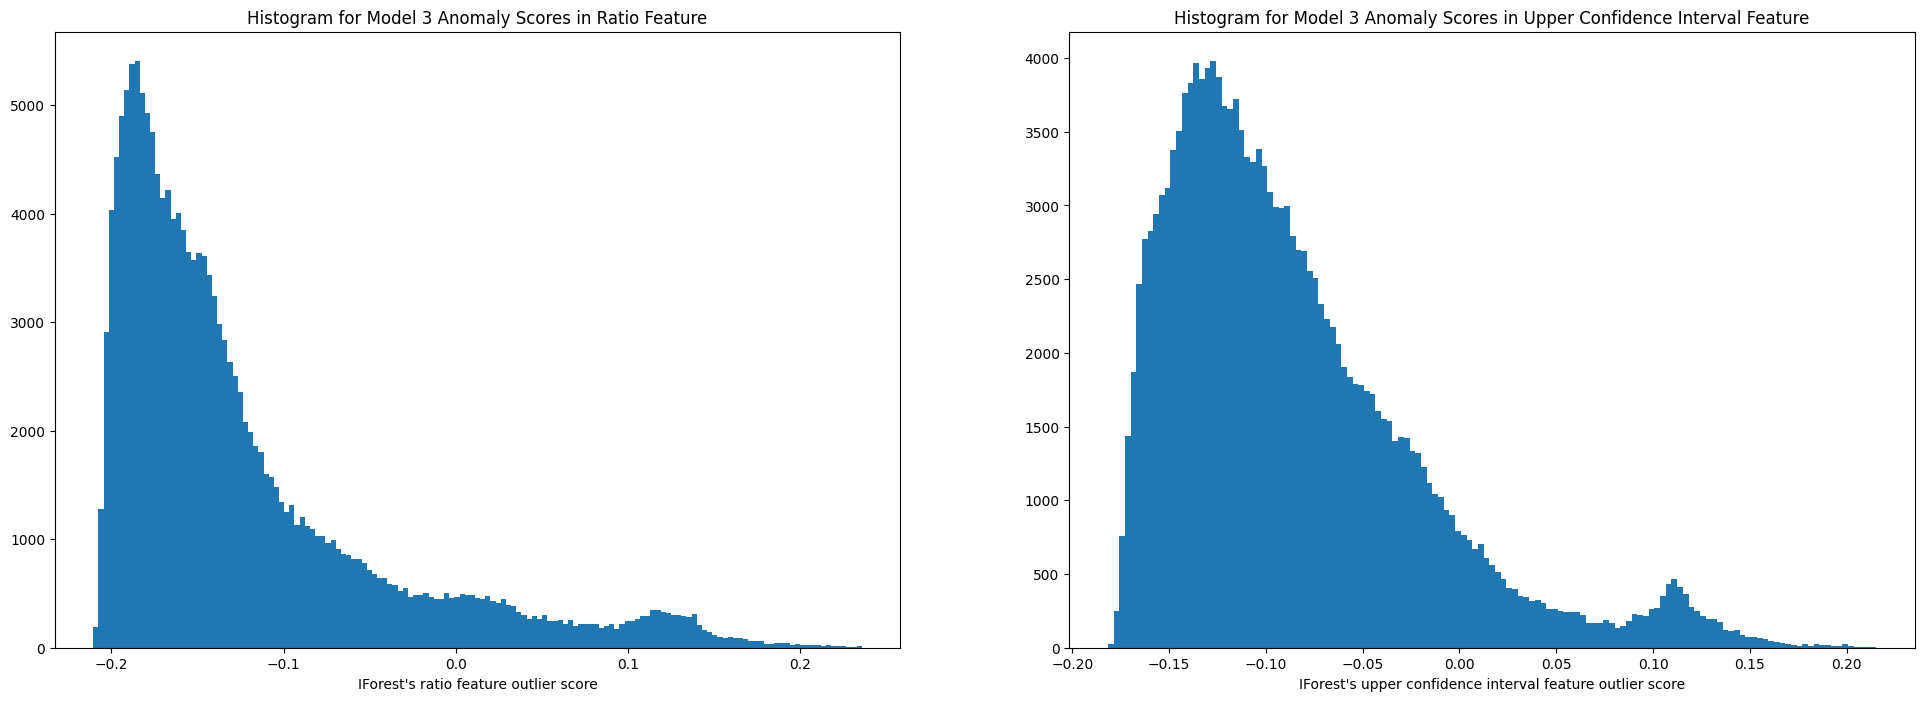

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.hist(r_scores, bins='auto')
ax1.set_title("Histogram for Model 3 Anomaly Scores in Ratio Feature")
ax1.set_xlabel("IForest's ratio feature outlier score")

ax2.hist(u_scores, bins='auto')
ax2.set_title("Histogram for Model 3 Anomaly Scores in Upper Confidence Interval Feature")
ax2.set_xlabel("IForest's upper confidence interval feature outlier score")

plt.show()

Both graphs in ratio and upper confidence interval features present right-skewed distribution. If we set the anomaly benchmark as 0, the scores that are greater than 0 are treated as outliers.